# Multinomial Logistic Regression

In [10]:
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

First, we load the data:

In [11]:
# Dataframe
path_df = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/Untitled Folder/Pickles_title/df.pickle"
with open(path_df, 'rb') as data:
    df = pickle.load(data)

# features_train
path_features_train = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/Untitled Folder/Pickles_title/features_train.pickle"
with open(path_features_train, 'rb') as data:
    features_train = pickle.load(data)

# labels_train
path_labels_train = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/Untitled Folder/Pickles_title/labels_train.pickle"
with open(path_labels_train, 'rb') as data:
    labels_train = pickle.load(data)

# features_test
path_features_test = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/Untitled Folder/Pickles_title/features_test.pickle"
with open(path_features_test, 'rb') as data:
    features_test = pickle.load(data)

# labels_test
path_labels_test = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/Untitled Folder/Pickles_title/labels_test.pickle"
with open(path_labels_test, 'rb') as data:
    labels_test = pickle.load(data)

Let's check the dimension of our feature vectors:

In [12]:
print(features_train.shape)
print(features_test.shape)

(2676, 300)
(473, 300)


## Cross-Validation for Hyperparameter tuning

First, we can see what hyperparameters the model has:

In [13]:
lr_0 = LogisticRegression(random_state = 8)

print('Parameters currently in use:\n')
pprint(lr_0.get_params())

Parameters currently in use:

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 8,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


We'll tune the following ones:

* `C` = Inverse of regularization strength. Smaller values specify stronger regularization.
* `multi_class` = We'll choose `multinomial` because this is a multi-class problem.
* `solver` = Algorithm to use in the optimization problem. For multiclass problems, only `newton-cg`, `sag`, `saga` and `lbfgs` handle multinomial loss.
* `class_weight`: Weights associated with classes. 
* `penalty`: Used to specify the norm used in the penalization. The ‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support only l2 penalties.

### Randomized Search Cross Validation

We first need to define the grid:

In [14]:
# C
C = [float(x) for x in np.linspace(start = 0.1, stop = 1, num = 10)]

# multi_class
multi_class = ['multinomial']

# solver
solver = ['newton-cg', 'sag', 'saga', 'lbfgs']
 
# class_weight
class_weight = ['balanced', None]

# penalty
penalty = ['l2']

# Create the random grid
random_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

print(random_grid)

{'C': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9, 1.0], 'multi_class': ['multinomial'], 'solver': ['newton-cg', 'sag', 'saga', 'lbfgs'], 'class_weight': ['balanced', None], 'penalty': ['l2']}


Then, we'll perform the Random Search:

In [31]:
# First create the base model to tune
lrc = LogisticRegression(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=lrc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=LogisticRegression(random_state=8),
                   n_iter=50,
                   param_distributions={'C': [0.1, 0.2, 0.30000000000000004,
                                              0.4, 0.5, 0.6, 0.7000000000000001,
                                              0.8, 0.9, 1.0],
                                        'class_weight': ['balanced', None],
                                        'multi_class': ['multinomial'],
                                        'penalty': ['l2'],
                                        'solver': ['newton-cg', 'sag', 'saga',
                                                   'lbfgs']},
                   random_state=8, scoring='accuracy', verbose=1)

We can see the best hyperparameters resulting from the Random Search:

In [32]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'solver': 'sag', 'penalty': 'l2', 'multi_class': 'multinomial', 'class_weight': 'balanced', 'C': 1.0}

The mean accuracy of a model with these hyperparameters is:
0.9174140508221226


After that, we can do a more exhaustive search centered in those values:

### Grid Search Cross Validation

In [52]:
# Create the parameter grid based on the results of random search 
C = [float(x) for x in np.linspace(start = 0.6, stop = 1.0, num = 10)]
multi_class = ['multinomial']
solver = ['sag']
class_weight = ['balanced']
penalty = ['l2']

param_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

# Create a base model
lrc = LogisticRegression(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=lrc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             estimator=LogisticRegression(random_state=8),
             param_grid={'C': [0.6, 0.6444444444444444, 0.6888888888888889,
                               0.7333333333333333, 0.7777777777777778,
                               0.8222222222222222, 0.8666666666666667,
                               0.9111111111111111, 0.9555555555555555, 1.0],
                         'class_weight': ['balanced'],
                         'multi_class': ['multinomial'], 'penalty': ['l2'],
                         'solver': ['sag']},
             scoring='accuracy', verbose=1)

The best hyperparameters turn out to be:

In [54]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'C': 0.6, 'class_weight': 'balanced', 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'sag'}

The mean accuracy of a model with these hyperparameters is:
0.9234539969834087


Let's save the model in `best_lrc`:

In [55]:
best_lrc = grid_search.best_estimator_

In [56]:
best_lrc

LogisticRegression(C=0.6, class_weight='balanced', multi_class='multinomial',
                   random_state=8, solver='sag')

We now know the best logistic regression model. Let's fit it and see how it performs:

## Model fit and performance

Now, we can fit the model to our training data:

In [57]:
best_lrc.fit(features_train, labels_train)

LogisticRegression(C=0.6, class_weight='balanced', multi_class='multinomial',
                   random_state=8, solver='sag')

And get the predictions:

In [58]:
lrc_pred = best_lrc.predict(features_test)

The conditional class probabilities can be obtained by typing:

`lrc_pred = best_lrc.predict_proba(features_test)`

For performance analysis, we will use the confusion matrix, the classification report and the accuracy on both training and test data:

#### Training accuracy

In [59]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_lrc.predict(features_train)))

The training accuracy is: 
0.9439461883408071


#### Test accuracy

In [60]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, lrc_pred))

The test accuracy is: 
0.9260042283298098


#### Classification report

In [61]:
# Classification report
print("Classification report")
print(classification_report(labels_test,lrc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       226
           1       0.96      0.93      0.95        86
           2       0.79      0.90      0.84        73
           3       0.85      0.76      0.80        88

    accuracy                           0.93       473
   macro avg       0.90      0.90      0.90       473
weighted avg       0.93      0.93      0.93       473



#### Confusion matrix

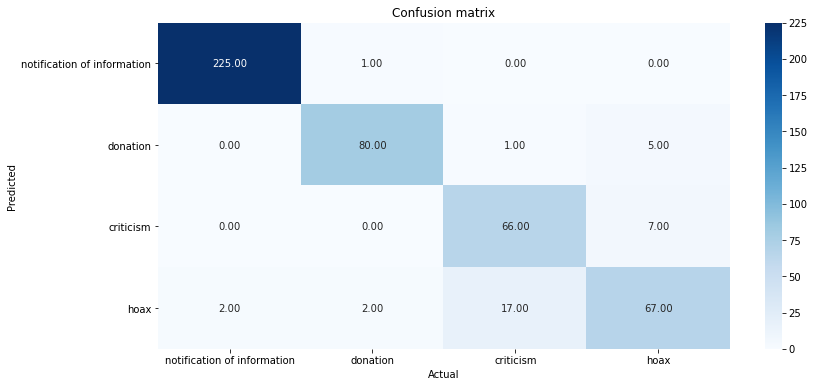

In [62]:
aux_df = df[['label', 'label_code']].drop_duplicates().sort_values('label_code')
conf_matrix = confusion_matrix(labels_test, lrc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['label'].values, 
            yticklabels=aux_df['label'].values,
            cmap="Blues",fmt='.2f')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

At this point, we could get the average time the model takes to get predictions. We want the algorithm to be fast since we are creating an app which will gather data from the internet and get the predicted categories. However, since the difference when predicting 10-20 observations will be very little, we won't take this into account.

However, the code below could do this task:

```python
features_time = features_train
elapsed_list = []
for i in range(0,10):
    
    start = time.time()
    predictions = best_lrc.predict(features_time)
    end = time.time()
    elapsed = end - start
    elapsed_list.append(elapsed)

mean_time_elapsed = np.mean(elapsed_list)
```

Let's see if the hyperparameter tuning process has returned a better model:

In [63]:
base_model = LogisticRegression(random_state = 8)
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.9302325581395349

In [64]:
best_lrc.fit(features_train, labels_train)
accuracy_score(labels_test, best_lrc.predict(features_test))

0.9260042283298098

We get approximately the same accuracy.

We'll create a dataset with a model summary to compare models:

In [65]:
d = {
     'Model': 'Logistic Regression',
     'Training Set Accuracy': accuracy_score(labels_train, best_lrc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, lrc_pred)
}

df_models_lrc = pd.DataFrame(d, index=[0])

In [66]:
df_models_lrc

,Model,Training Set Accuracy,Test Set Accuracy
0,Logistic Regression,0.943946,0.926004


Let's save the model and this dataset:

In [67]:
with open('Models/best_lrc.pickle', 'wb') as output:
    pickle.dump(best_lrc, output)
    
with open('Models/df_models_lrc.pickle', 'wb') as output:
    pickle.dump(df_models_lrc, output)

In [33]:
# Dataframe
path_df = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/03. Feature Engineering/Pickles_title/df.pickle"
with open(path_df, 'rb') as data:
    df = pickle.load(data)
    
# X_train
path_X_train = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/03. Feature Engineering/Pickles_title/X_train.pickle"
with open(path_X_train, 'rb') as data:
    X_train = pickle.load(data)

# X_test
path_X_test = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/03. Feature Engineering/Pickles_title/X_test.pickle"
with open(path_X_test, 'rb') as data:
    X_test = pickle.load(data)

# y_train
path_y_train = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/03. Feature Engineering/Pickles_title/y_train.pickle"
with open(path_y_train, 'rb') as data:
    y_train = pickle.load(data)

# y_test
path_y_test = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/03. Feature Engineering/Pickles_title/y_test.pickle"
with open(path_y_test, 'rb') as data:
    y_test = pickle.load(data)

# features_train
path_features_train = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/03. Feature Engineering/Pickles_title/features_train.pickle"
with open(path_features_train, 'rb') as data:
    features_train = pickle.load(data)

# labels_train
path_labels_train = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/03. Feature Engineering/Pickles_title/labels_train.pickle"
with open(path_labels_train, 'rb') as data:
    labels_train = pickle.load(data)

# features_test
path_features_test = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/03. Feature Engineering/Pickles_title/features_test.pickle"
with open(path_features_test, 'rb') as data:
    features_test = pickle.load(data)

# labels_test
path_labels_test = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/03. Feature Engineering/Pickles_title/labels_test.pickle"
with open(path_labels_test, 'rb') as data:
    labels_test = pickle.load(data)
    
# SVM Model
path_model = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/04. Model Training/Models/best_lrc.pickle"
with open(path_model, 'rb') as data:
    svc_model = pickle.load(data)
    
# Category mapping dictionary
category_codes = {
    'notification of information': 0,
    'donation': 1,
    'criticism': 2,
    'hoax': 3,
}

category_names = {
    0: 'notification of information',
    1: 'donation',
    2: 'criticism',
    3: 'hoax'
}

D:\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [161]:
predictions = svc_model.predict(features_test)

In [162]:
# Indexes of the test set
index_X_test = X_test.index

# We get them from the original df
df_test = df.loc[index_X_test]

# Add the predictions
df_test['prediction'] = predictions

# Clean columns
df_test = df_test[['title', 'label', 'label_code', 'prediction']]

# Decode
df_test['label_predicted'] = df_test['prediction']
df_test = df_test.replace({'label_predicted':category_names})

# Clean columns again
df_test = df_test[['title', 'label', 'label_predicted']]

In [163]:
df_test.head()

,title,label,label_predicted
2182,Update Corona Indonesia 24 Oktober 2020 dan Se...,notification of information,notification of information
1279,Pertamina Diminta Lihat Fluktuasi Harga Minyak...,criticism,criticism
1729,UPDATE 17 Januari: Ada 145.482 Kasus Aktif Cov...,notification of information,notification of information
1477,"Sebaran 4.002 Kasus Positif Hari Ini, DKI-Jaba...",donation,donation
1964,UPDATE Corona 31 Maret di 32 Provinsi: Kasus B...,notification of information,notification of information


In [164]:
condition = (df_test['label'] != df_test['label_predicted'])

df_misclassified = df_test[condition]
df_misclassified.head(5)

,title,label,label_predicted
1454,Satgas Covid-19 dan Polda Jabar Diminta Panggi...,criticism,hoax
1323,Polri Tak Akan Berikan Sanksi Hukum Ataupun De...,donation,hoax
360,Buntut Kasus Kerumunan Massa Rizieq Shihab: Gi...,criticism,hoax
945,Kominfo Catat Ada 2 Ribu Lebih Konten Hoax Ten...,hoax,criticism
1324,Polri Tidak Berikan Izin Keramaian Pelaksanaan...,donation,criticism


In [165]:
len(df_misclassified)

33

In [166]:
condition = (df_test['label'] != df_test['label_predicted'])

df_misclassified = df_test[condition]
df_misclassified.head(5)

,title,label,label_predicted
1454,Satgas Covid-19 dan Polda Jabar Diminta Panggi...,criticism,hoax
1323,Polri Tak Akan Berikan Sanksi Hukum Ataupun De...,donation,hoax
360,Buntut Kasus Kerumunan Massa Rizieq Shihab: Gi...,criticism,hoax
945,Kominfo Catat Ada 2 Ribu Lebih Konten Hoax Ten...,hoax,criticism
1324,Polri Tidak Berikan Izin Keramaian Pelaksanaan...,donation,criticism


In [167]:
def output_article(row_article):
    print('Actual Category: %s' %(row_article['label']))
    print('Predicted Category: %s' %(row_article['label_predicted']))
    print('-------------------------------------------')
    print('Text: ')
    print('%s' %(row_article['title']))

In [168]:
import random
random.seed()
list_samples = random.sample(list(df_misclassified.index), 3)
list_samples

[1324, 73, 1595]

In [169]:
output_article(df_misclassified.loc[list_samples[0]])

Actual Category: donation
Predicted Category: criticism
-------------------------------------------
Text: 
Polri Tidak Berikan Izin Keramaian Pelaksanaan Liga 1 dan 2 Indonesia, Ini Alasannya 
